In [1]:
# cd /content/drive/My Drive/Colab Notebooks/pix2pix

In [2]:
# !pip install matplotlib

In [3]:
import tensorflow as tf

import os
import time

from matplotlib import pyplot as plt
from IPython import display

from absl import logging


In [4]:
def set_memory_growth():
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        try:
            # Currently, memory growth needs to be the same across GPUs
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
                logical_gpus = tf.config.experimental.list_logical_devices(
                    'GPU')
                logging.info(
                    "Detect {} Physical GPUs, {} Logical GPUs.".format(
                        len(gpus), len(logical_gpus)))
        except RuntimeError as e:
            # Memory growth must be set before GPUs have been initialized
            logging.info(e)
    else:
        logging.info("No GPU found!")

In [5]:
set_memory_growth()
tf.config.experimental.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [6]:
# _URL = 'https://people.eecs.berkeley.edu/~tinghuiz/projects/pix2pix/datasets/facades.tar.gz'

# path_to_zip = tf.keras.utils.get_file('facades.tar.gz', origin=_URL, extract=True)

# PATH = os.path.join(os.path.dirname(path_to_zip), 'facades/')
PATH = 'facades/'

In [7]:
BUFFER_SIZE = 400
BATCH_SIZE = 16
IMG_WIDTH = 256
IMG_HEIGHT = 256

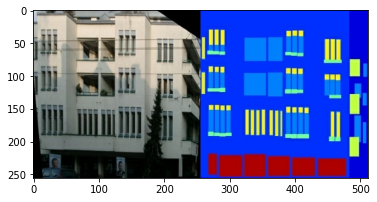

In [8]:
# PATH = 'data/'
image = tf.io.read_file(PATH + 'train/1.jpg')
image = tf.image.decode_jpeg(image)
image = tf.cast(image, tf.float32)

plt.figure()
plt.imshow(image / 255.)


In [9]:
def load(file):
    image = tf.io.read_file(file)
    image = tf.image.decode_jpeg(image)

    w = tf.shape(image)[1]

    w = w // 2
    real = image[:, :w, :]
    input = image[:, w:, :]

    input = tf.cast(input, tf.float32)
    real = tf.cast(real, tf.float32)

    return input, real

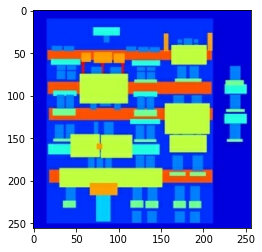

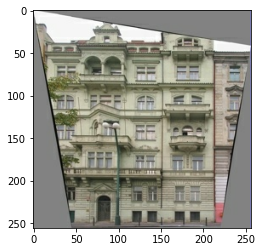

In [10]:
inp, re = load(PATH + 'train/100.jpg')
plt.figure()
plt.imshow(inp / 255.)
plt.figure()
plt.imshow(re / 255.)

In [11]:
def resize(input, real, height, width):
    input = tf.image.resize(input, [height, width], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    real = tf.image.resize(real, [height, width], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

    return input, real


In [12]:
def random_crop(input, real):
    stack = tf.stack([input, real], axis=0)
    cropped = tf.image.random_crop(stack, size=[2, IMG_HEIGHT, IMG_WIDTH, 3])
    return cropped[0], cropped[1]

In [13]:
def normalize(input, real):
    input = (input / 127.5) - 1
    real = (real / 127.5) - 1

    return input, real

In [14]:
@tf.function
def random_jitter(input, real):
    input, real = resize(input, real, 286, 286)
    input, real = random_crop(input, real)
    
    if tf.random.uniform(()) > 0.5:
        input = tf.image.flip_left_right(input)
        real = tf.image.flip_left_right(real)

    return input, real

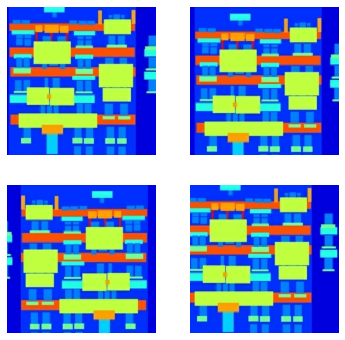

In [15]:
plt.figure(figsize=(6, 6))
for i in range(4):
    jitter_input, jitter_real = random_jitter(inp, re)
    plt.subplot(2, 2, i + 1)
    plt.imshow(jitter_input / 255.)
    plt.axis('off')

plt.show()

In [16]:
def load_train_images(file):
    input, real = load(file)
    input, real = random_jitter(input, real)
    input, real = normalize(input, real)

    return input, real

In [17]:
def load_test_images(file):
    input, real = load(file)
    input, real = resize(input, real, IMG_HEIGHT, IMG_WIDTH)
    input, real = normalize(input, real)

    return input, real

In [18]:
train_dataset = tf.data.Dataset.list_files(PATH + "train/*.jpg")
train_dataset = train_dataset.map(load_train_images, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [19]:
test_dataset = tf.data.Dataset.list_files(PATH + "test/*.jpg")
test_dataset = test_dataset.map(load_test_images)
test_dataset = test_dataset.batch(BATCH_SIZE)

In [20]:
OUTPUT_CHANNELS = 3

## Build the Generator
- The architecture of generator is a modified U-Net.
- Each block in the encoder is (Conv -> Batchnorm -> Leaky ReLU)
- Each block in the decoder is (Transposed Conv -> Batchnorm -> Dropout(applied to the first 3 blocks) -> ReLU)
- There are skip connections between the encoder and decoder (as in U-Net).

In [21]:
def downsample(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Conv2D(filters, size, strides=2, padding="same", kernel_initializer=initializer, use_bias=False))
    if apply_batchnorm:
        model.add(tf.keras.layers.BatchNormalization())

    model.add(tf.keras.layers.LeakyReLU())

    return model

In [22]:
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)

    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Conv2DTranspose(filters, size, strides=2, padding="same", kernel_initializer=initializer, use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    if apply_dropout:
        model.add(tf.keras.layers.Dropout(0.5))
    
    model.add(tf.keras.layers.ReLU())

    return model

In [23]:
def Generator():
    inputs = tf.keras.layers.Input(shape=[256, 256, 3])

    down_stack = [
        downsample(64, 4, False),
        downsample(128, 4),
        downsample(256, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
    ]

    upstack = [
        upsample(512, 4, True),
        upsample(512, 4, True),
        upsample(512, 4, True),
        upsample(512, 4),
        upsample(256, 4),
        upsample(128, 4),
        upsample(64, 4),
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4, strides=2, padding="same", kernel_initializer=initializer, activation="tanh")

    x = inputs

    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    for up, skip in zip(upstack, skips):
        x = up(x)
        x = tf.keras.layers.Concatenate()([x, skip])

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

In [24]:
generator = Generator()
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.


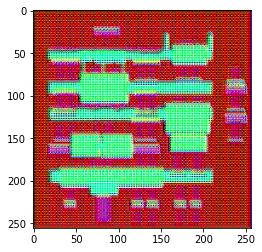

In [25]:
generated = generator(inp[tf.newaxis, ...], training=False)
plt.imshow(generated[0,...])

##Generator loss
- It is a sigmoid cross entropy loss of the generated images and an array of ones.
- The paper also includes L1 loss which is MAE (mean absolute error) between the generated image and the target image.
- This allows the generated image to become structurally similar to the target image.
- The formula to calculate the total generator loss = gan_loss + LAMBDA * l1_loss, where LAMBDA = 100. This value was decided by the authors of the paper.

In [26]:
LAMBDA = 100

In [27]:
def generator_loss(disc_output, gen_output, target):
    gan_loss = loss_object(tf.ones_like(disc_output), disc_output)
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
    total_loss = gan_loss + (LAMBDA * l1_loss)

    return total_loss, gan_loss, l1_loss

##Build the Discriminator
- The Discriminator is a PatchGAN.
- Each block in the discriminator is (Conv -> BatchNorm -> Leaky ReLU)
- The shape of the output after the last layer is (batch_size, 30, 30, 1)
- Each 30x30 patch of the output classifies a 70x70 portion of the input image (such an architecture is called a PatchGAN).
- Discriminator receives 2 inputs.
    - Input image and the target image, which it should classify as real.
    - Input image and the generated image (output of generator), which it should classify as fake.
    - We concatenate these 2 inputs together in the code (tf.concat([inp, tar], axis=-1))

In [28]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)

    input = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')
    target = tf.keras.layers.Input(shape=[256, 256, 3], name='target_image')

    x = tf.keras.layers.concatenate([input, target])

    down1 = downsample(64, 4, False)(x)
    down2 = downsample(128, 4)(down1)
    down3 = downsample(256, 4)(down2)

    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)
    conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                            kernel_initializer=initializer,
                            use_bias=False)(zero_pad1)

    batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

    leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)

    last = tf.keras.layers.Conv2D(1, 4, strides=1,
                            kernel_initializer=initializer)(zero_pad2)

    return tf.keras.Model(inputs=[input, target], outputs=last)

In [29]:
discriminator = Discriminator()
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.


In [30]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [31]:
def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

    generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

    total_disc_loss = real_loss + generated_loss

    return total_disc_loss

In [32]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [33]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [34]:
def generate_images(model, test_input, tar):
    prediction = model(test_input, training=True)
    plt.figure(figsize=(15,15))

    display_list = [test_input[0], tar[0], prediction[0]]
    title = ['Input Image', 'Ground Truth', 'Predicted Image']

    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        # getting the pixel values between [0, 1] to plot it.
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()

In [35]:
EPOCHS = 300

In [36]:
import datetime
log_dir="logs/"

summary_writer = tf.summary.create_file_writer(log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [37]:
@tf.function
def train_step(input, target, epoch):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated = generator(input_image, training=True)
        
        real = discriminator([input, target], training=True)
        fake = discriminator([input, generated], training=True)

        gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(fake, generated, target)
        disc_loss = discriminator_loss(real, fake)

    generator_gradients = gen_tape.gradient(gen_total_loss, generator.trainable_variables)
    disc_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(disc_gradients, discriminator.trainable_variables))

    with summary_writer.as_default():
        tf.summary.scalar('gen_total_loss', gen_total_loss, step=epoch)
        tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=epoch)
        tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=epoch)
        tf.summary.scalar('disc_loss', disc_loss, step=epoch)


Epoch: 107 

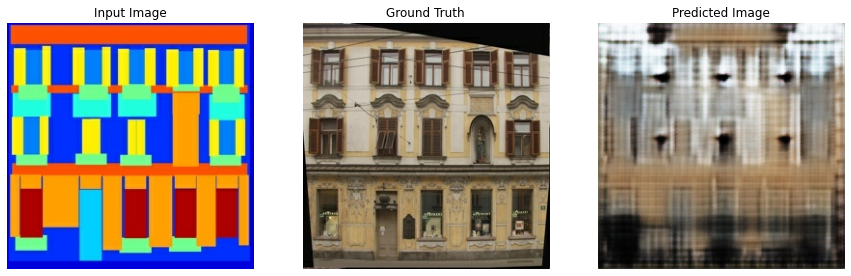

KeyboardInterrupt: 

In [38]:
for epoch in range(EPOCHS):
    display.clear_output(wait=True)
    print("Epoch: " + str(epoch), end=" ")

    for example_input, example_target in test_dataset.take(1):
        generate_images(generator, example_input, example_target)

    for n, (input_image, target) in train_dataset.enumerate():
        if (n + 1) % 100 == 0:
            print(n)
        train_step(input_image, target, epoch)

#         if (epoch + 1) % 20 == 0:
#             checkpoint.save(file_prefix=checkpoint_prefix)

checkpoint.save(file_prefix=checkpoint_prefix)